## New Cross Validation Scheme
- Just doing cross validation on the whole test data and then averaging these to submit to the leaderboard has a few flaws:
    - potential overfit to leaderboard since we are using that for model validation
    - potential data leakage in each fold
    
- to do a proper model validation, it is good practice to have an extra holdout set to test the model predictions. If the holdout set predictions are not too different from the CV performance then we can be more confident on generalisation to new data
- disadvantage is less data for training the model (we can't do this well if we have a small dataset)

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean

# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Cross Validation folds + Holdout set (separate from leaderboard test set))
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [2]:
train_full = pd.read_pickle('data/train_feat.pkl')
test_full = pd.read_pickle('data/test_feat.pkl')

# Label Encoding for categoricals
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 

# Fill NA's for numerics
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

In [3]:
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud'                         
]

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [5]:
# X = train_full[features_columns]
# y = train_full['isFraud']

# Split holdout as 15% of the train set
X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], test_size=0.15, random_state=42)

del train_full
gc.collect()

44

In [23]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves': 200, #2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': 8, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':1000, # I'll keep it to 1000 estimators since its obviously overfitting on the training set and need to train faster
                    'max_bin':150, # less bins
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [24]:
NFOLDS =5
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=True) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
    holdout_pred = clf.predict(X_holdout)
    print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.970625	valid_1's auc: 0.946952
[400]	training's auc: 0.986641	valid_1's auc: 0.959896
[600]	training's auc: 0.993689	valid_1's auc: 0.965567
[800]	training's auc: 0.9973	valid_1's auc: 0.96942
[1000]	training's auc: 0.998888	valid_1's auc: 0.971208
Did not meet early stopping. Best iteration is:
[999]	training's auc: 0.998888	valid_1's auc: 0.971207
AUC for validation fold 1: 0.9712071250901613
AUC for holdout set - fold  0.9700988294770166
Training on fold 2


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971841	valid_1's auc: 0.94693
[400]	training's auc: 0.98683	valid_1's auc: 0.957443
[600]	training's auc: 0.993978	valid_1's auc: 0.963571
[800]	training's auc: 0.997447	valid_1's auc: 0.966702
[1000]	training's auc: 0.998946	valid_1's auc: 0.968909
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998946	valid_1's auc: 0.968909
AUC for validation fold 2: 0.9689089224702698
AUC for holdout set - fold  0.9721700956644252
Training on fold 3


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972511	valid_1's auc: 0.944618
[400]	training's auc: 0.987073	valid_1's auc: 0.955414
[600]	training's auc: 0.99447	valid_1's auc: 0.961646
[800]	training's auc: 0.997679	valid_1's auc: 0.964915
[1000]	training's auc: 0.999079	valid_1's auc: 0.966572
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.999079	valid_1's auc: 0.966572
AUC for validation fold 3: 0.9665715544808
AUC for holdout set - fold  0.970456543452424
Training on fold 4


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971971	valid_1's auc: 0.946597
[400]	training's auc: 0.986926	valid_1's auc: 0.958226
[600]	training's auc: 0.99383	valid_1's auc: 0.963527
[800]	training's auc: 0.997354	valid_1's auc: 0.96689
[1000]	training's auc: 0.998945	valid_1's auc: 0.968953
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998945	valid_1's auc: 0.968953
AUC for validation fold 4: 0.9689527022329432
AUC for holdout set - fold  0.9713269697718633
Training on fold 5


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972246	valid_1's auc: 0.943957
[400]	training's auc: 0.986021	valid_1's auc: 0.955014
[600]	training's auc: 0.993932	valid_1's auc: 0.961033
[800]	training's auc: 0.997497	valid_1's auc: 0.964211
[1000]	training's auc: 0.998993	valid_1's auc: 0.965628
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998993	valid_1's auc: 0.965628
AUC for validation fold 5: 0.9656283625508472
AUC for holdout set - fold  0.9707565138116423
Cross Validation AUC:  0.9682537333650043


The average AUC for the timeseries split is much lower, and the LB score is a lower too. Might not be the correct CV scheme for time series as well. Still inconclusive

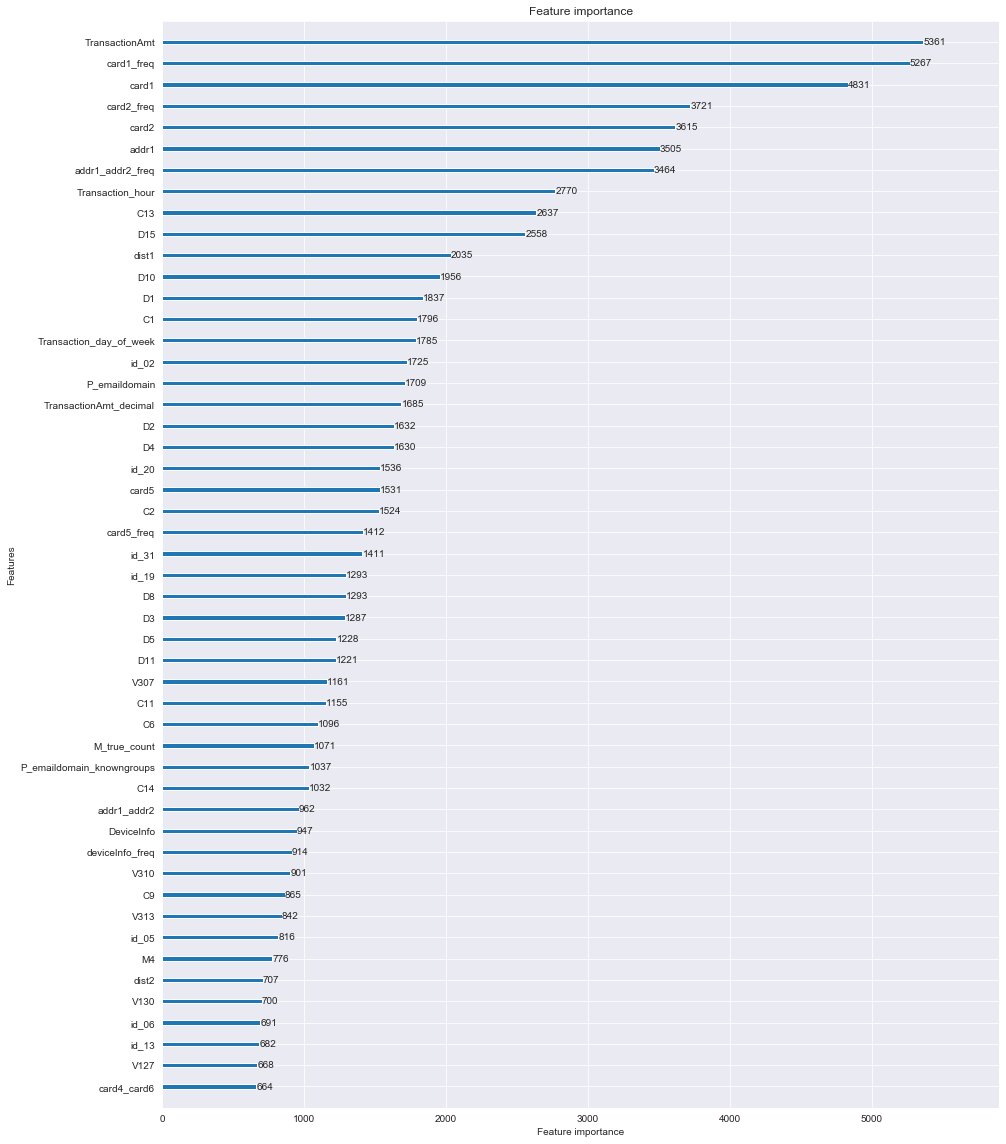

In [25]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [26]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_CV_holdout.csv')